In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv")
df.head(20)

,sf,mesos,success,maintain,degrade,break
0,0,10000,1.00,0.00,0.00,0.00
1,1,15000,0.95,0.05,0.00,0.00
2,2,30000,0.90,0.10,0.00,0.00
3,3,55000,0.85,0.15,0.00,0.00
4,4,100000,0.80,0.20,0.00,0.00
5,5,180000,0.75,0.25,0.00,0.00
6,6,270000,0.70,0.30,0.00,0.00
7,7,360000,0.65,0.35,0.00,0.00
8,8,450000,0.60,0.40,0.00,0.00
9,9,540000,0.55,0.45,0.00,0.00


In [2]:
# 350 crystal per scroll
decline_scroll_cost = 350 / 3 
shield_scroll_cost = 350 / 3 

# 160m mesos for 7% luky scroll
lucky_scroll_cost = 160_000_000 

In [3]:
class Gear:
    
    def __init__(self, current_sf=0, max_sf=30):
        self.max_sf = max_sf
        self.current_sf = current_sf
        self.broken = 0
        self.attempt = 0
        
        self.mesos_cost = 0
        self.crystal_cost = 0
    
    def rng(self):
        return random.random()
    
    @property
    def success(self):
        return df.iloc[self.current_sf]['success']
    
    @property
    def maintain(self):
        return df.iloc[self.current_sf]['maintain']
    
    @property
    def degrade(self):
        return df.iloc[self.current_sf]['degrade']
    
    @property
    def destroy(self):
        return df.iloc[self.current_sf]['break']
    
    @property
    def mesos(self):
        return df.iloc[self.current_sf]['mesos']
        
    def enhance(self, use_decline_scroll=False, use_shield_scroll=False, use_lucky_scroll=False):
        self.attempt += 1
        self.mesos_cost += self.mesos
        
        success_thresh = self.success
        if use_lucky_scroll:
            success_thresh += 0.07
            self.mesos_cost += lucky_scroll_cost
        
        degrade_thresh = success_thresh + self.degrade
        if use_decline_scroll:
            degrade_thresh = success_thresh
            self.crystal_cost += decline_scroll_cost
        
        break_thresh = degrade_thresh + self.destroy
        if use_shield_scroll:
            break_thresh = degrade_thresh
            self.crystal_cost += shield_scroll_cost
        
        rn = self.rng()
        if rn <= success_thresh:
            self.current_sf += 1
        elif rn <= degrade_thresh:
            self.current_sf -= 1
        elif rn <= break_thresh:
            # equipment breaks, reset SF to zero
            self.current_sf = 0
            self.broken += 1
        else:
            # maintain current level
            pass
        
    def __str__(self):
        return f"current sf: {self.current_sf}, mesos cost: {self.mesos_cost}, crystal cost: {self.crystal_cost}, attempt: {self.attempt}, broke: {self.broken}"

#### Trial Run SF 1-15

In [4]:
gear = Gear(current_sf=0)
while gear.current_sf != 15:
    gear.enhance()
    print(gear)

current sf: 1, mesos cost: 10000.0, crystal cost: 0, attempt: 1, broke: 0
current sf: 2, mesos cost: 25000.0, crystal cost: 0, attempt: 2, broke: 0
current sf: 3, mesos cost: 55000.0, crystal cost: 0, attempt: 3, broke: 0
current sf: 4, mesos cost: 110000.0, crystal cost: 0, attempt: 4, broke: 0
current sf: 5, mesos cost: 210000.0, crystal cost: 0, attempt: 5, broke: 0
current sf: 6, mesos cost: 390000.0, crystal cost: 0, attempt: 6, broke: 0
current sf: 7, mesos cost: 660000.0, crystal cost: 0, attempt: 7, broke: 0
current sf: 8, mesos cost: 1020000.0, crystal cost: 0, attempt: 8, broke: 0
current sf: 8, mesos cost: 1470000.0, crystal cost: 0, attempt: 9, broke: 0
current sf: 8, mesos cost: 1920000.0, crystal cost: 0, attempt: 10, broke: 0
current sf: 9, mesos cost: 2370000.0, crystal cost: 0, attempt: 11, broke: 0
current sf: 9, mesos cost: 2910000.0, crystal cost: 0, attempt: 12, broke: 0
current sf: 9, mesos cost: 3450000.0, crystal cost: 0, attempt: 13, broke: 0
current sf: 10, me

#### Trial Run SF 15-20 (no scroll)

In [5]:
gear = Gear(current_sf=15)
while gear.current_sf != 20:
    gear.enhance()
    
print(gear)
print(f"mesos: {gear.mesos_cost}, crystal: {gear.crystal_cost}")

current sf: 20, mesos cost: 5290195000.0, crystal cost: 0, attempt: 6633, broke: 189
mesos: 5290195000.0, crystal: 0


#### Trial Run SF 15-20 (use scroll)

In [6]:
gear = Gear(current_sf=15)
print("start:", gear)
while gear.current_sf != 20:
    gear.enhance(use_decline_scroll=True, use_lucky_scroll=False, use_shield_scroll=True)
    print(gear)
    
print("end:", gear)
print(f"mesos: {gear.mesos_cost}, crystal: {gear.crystal_cost}")

start: current sf: 15, mesos cost: 0, crystal cost: 0, attempt: 0, broke: 0
current sf: 15, mesos cost: 1600000.0, crystal cost: 233.33333333333334, attempt: 1, broke: 0
current sf: 15, mesos cost: 3200000.0, crystal cost: 466.6666666666667, attempt: 2, broke: 0
current sf: 15, mesos cost: 4800000.0, crystal cost: 700.0, attempt: 3, broke: 0
current sf: 15, mesos cost: 6400000.0, crystal cost: 933.3333333333333, attempt: 4, broke: 0
current sf: 15, mesos cost: 8000000.0, crystal cost: 1166.6666666666667, attempt: 5, broke: 0
current sf: 15, mesos cost: 9600000.0, crystal cost: 1400.0000000000002, attempt: 6, broke: 0
current sf: 15, mesos cost: 11200000.0, crystal cost: 1633.3333333333337, attempt: 7, broke: 0
current sf: 16, mesos cost: 12800000.0, crystal cost: 1866.6666666666672, attempt: 8, broke: 0
current sf: 16, mesos cost: 14800000.0, crystal cost: 2100.0000000000005, attempt: 9, broke: 0
current sf: 17, mesos cost: 16800000.0, crystal cost: 2333.3333333333335, attempt: 10, bro

#### Trial Run SF 20-30 (full scroll)

In [7]:
gear = Gear(current_sf=20)
print("start:", gear)
while gear.current_sf != 30:
    gear.enhance(use_decline_scroll=True, use_lucky_scroll=True, use_shield_scroll=True)    
print("end:", gear)
print(f"mesos: {gear.mesos_cost}, crystal: {gear.crystal_cost}")

start: current sf: 20, mesos cost: 0, crystal cost: 0, attempt: 0, broke: 0
end: current sf: 30, mesos cost: 25905900000.0, crystal cost: 36400.00000000006, attempt: 156, broke: 0
mesos: 25905900000.0, crystal: 36400.00000000006


### Monte Carlo Simulation
* Each experiment levels SF 20 to 30 using three scrolls.
* Run the experiment 10000 times. 
* Record mesos and crystal expense for each experiment
* Plot distribution

In [8]:
import numpy as np

trial = 1000
crystal_cost_array = np.zeros(trial)
mesos_cost_array = np.zeros(trial)
attempt_array = np.zeros(trial)
for i in range(trial):
    gear = Gear(current_sf=20)
    while gear.current_sf != 30:
        gear.enhance(use_decline_scroll=True, use_lucky_scroll=True, use_shield_scroll=True)
    
    crystal_cost_array[i] = gear.crystal_cost
    mesos_cost_array[i] = gear.mesos_cost
    attempt_array[i] = gear.attempt
    
    print(f"trial {i}/{trial}", end="\r")

In [9]:
from sklearn.neighbors import KernelDensity
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

average cost: 29084.53 crystal


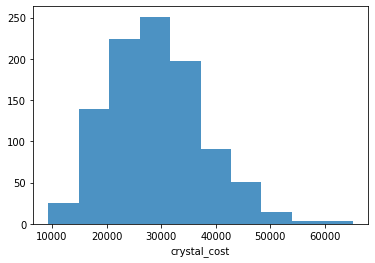

In [10]:
plt.hist(crystal_cost_array, alpha=0.8)
plt.xlabel("crystal_cost")
print("average cost: %.2f crystal"%np.mean(crystal_cost_array))

average cost: 21107929000.00 mesos


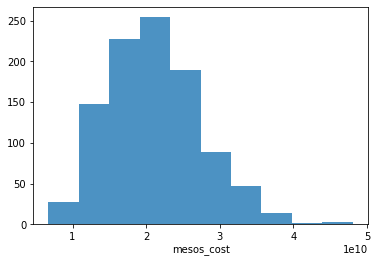

In [11]:
plt.hist(mesos_cost_array, alpha=0.8)
plt.xlabel("mesos_cost")
print("average cost: %.2f mesos"%np.mean(mesos_cost_array))

average attempt: 124.65


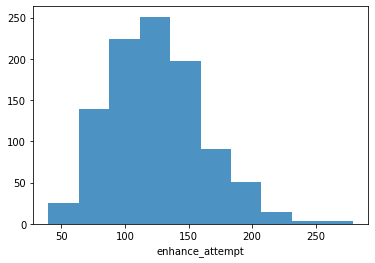

In [12]:
plt.hist(attempt_array, alpha=0.8)
plt.xlabel("enhance_attempt")
print("average attempt: %.2f"%np.mean(attempt_array))